In [1]:
import numpy as np
import pandas as pd
from matplotlib import pyplot as plt

In [2]:
import zipfile

# Path to your zip file
zip_path = '/content/archive (3).zip'

# Destination folder where files will be extracted
extract_path = '/content/extracted_files/'

# Open and extract the zip file
with zipfile.ZipFile(zip_path, 'r') as zip_ref:
    zip_ref.extractall(extract_path)


In [3]:
df=pd.read_csv("/content/extracted_files/Iris.csv")
df.head()

,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species
0,1,5.1,3.5,1.4,0.2,Iris-setosa
1,2,4.9,3.0,1.4,0.2,Iris-setosa
2,3,4.7,3.2,1.3,0.2,Iris-setosa
3,4,4.6,3.1,1.5,0.2,Iris-setosa
4,5,5.0,3.6,1.4,0.2,Iris-setosa


In [4]:
classes=df['Species'].unique()
classes

array(['Iris-setosa', 'Iris-versicolor', 'Iris-virginica'], dtype=object)

In [5]:
# Create a mapping dictionary
class_mapping = {'Iris-setosa': 0, 'Iris-versicolor': 1, 'Iris-virginica': 2}

# Use .replace() to perform the substitution
df['class_numerical'] = df['Species'].replace(class_mapping)
df.head()

<ipython-input-5-355f49b75174>:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df['class_numerical'] = df['Species'].replace(class_mapping)


,Id,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,Species,class_numerical
0,1,5.1,3.5,1.4,0.2,Iris-setosa,0
1,2,4.9,3.0,1.4,0.2,Iris-setosa,0
2,3,4.7,3.2,1.3,0.2,Iris-setosa,0
3,4,4.6,3.1,1.5,0.2,Iris-setosa,0
4,5,5.0,3.6,1.4,0.2,Iris-setosa,0


In [6]:
data=df.drop(['Species','Id'],axis=1)
data.head()

,SepalLengthCm,SepalWidthCm,PetalLengthCm,PetalWidthCm,class_numerical
0,5.1,3.5,1.4,0.2,0
1,4.9,3.0,1.4,0.2,0
2,4.7,3.2,1.3,0.2,0
3,4.6,3.1,1.5,0.2,0
4,5.0,3.6,1.4,0.2,0


In [7]:
data.shape

(150, 5)

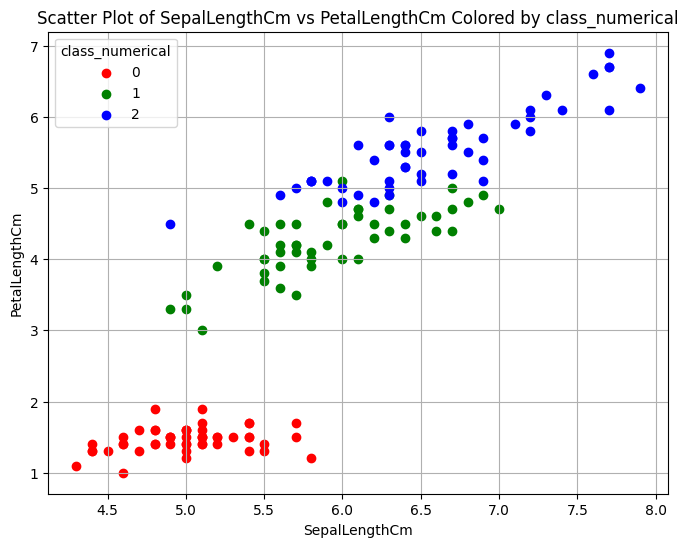

In [8]:
class_column='class_numerical'
feature_x="SepalLengthCm"
feature_y="PetalLengthCm"

unique_classes = df['class_numerical'].unique()

# Define a color map for your classes (you can customize these)
colors = {0: 'red', 1: 'green', 2: 'blue'}
# If your class labels are already 0, 1, 2, you can use a list of colors directly:
# colors = ['red', 'green', 'blue']

# Create the scatter plot
plt.figure(figsize=(8, 6))  # Adjust figure size if needed

for class_label in unique_classes:
    subset = df[df[class_column] == class_label]
    plt.scatter(subset[feature_x], subset[feature_y],
                label=class_label, color=colors.get(class_label))
    # If your class labels are numerical (0, 1, 2), you might do:
    # plt.scatter(subset[feature_x], subset[feature_y],
    #             label=f'Class {class_label}', color=colors[class_label])

plt.xlabel(feature_x)
plt.ylabel(feature_y)
plt.title(f'Scatter Plot of {feature_x} vs {feature_y} Colored by {class_column}')
plt.legend(title=class_column)
plt.grid(True)
plt.show()

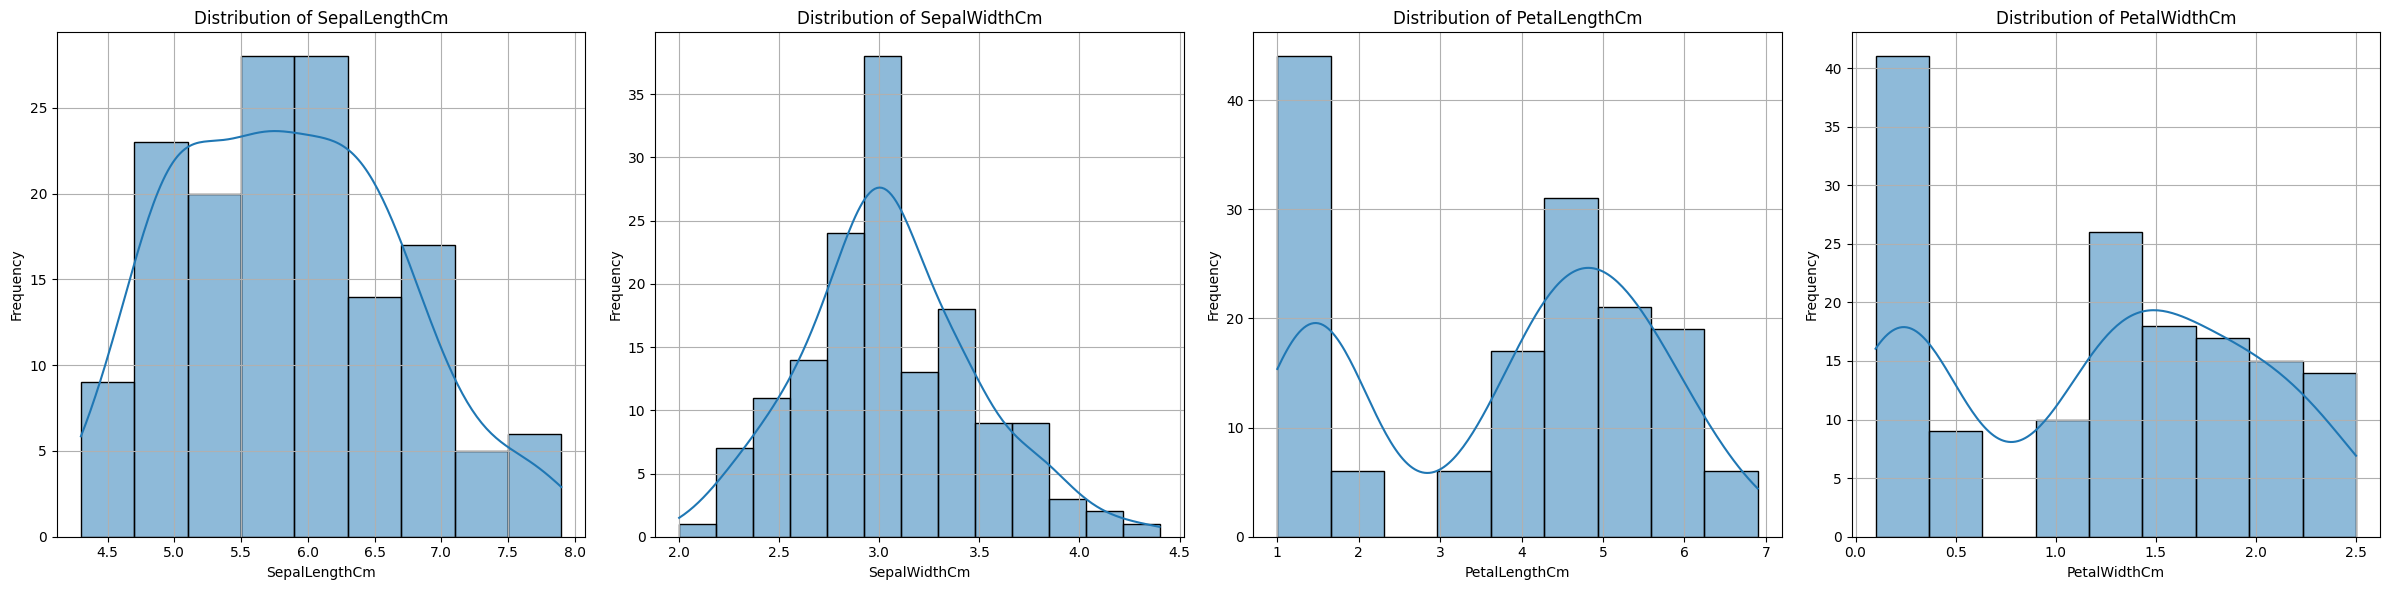

In [9]:

import seaborn as sns


# Assuming your DataFrame is named 'df' and contains continuous features
continuous_features = data.keys()[:-1] # Replace with your actual column names

num_features = len(continuous_features)
fig, axes = plt.subplots(nrows=1, ncols=num_features, figsize=(6*num_features, 6)) # Adjust figure height

for i, column in enumerate(continuous_features):
    sns.histplot(df[column], kde=True, ax=axes[i])  # Plot on the specific subplot
    axes[i].set_title(f'Distribution of {column}')
    axes[i].set_xlabel(column)
    axes[i].set_ylabel('Frequency')
    axes[i].grid(True)

plt.tight_layout()  # Adjust subplot parameters for a tight layout
plt.show()

## Random Forest Pipeline Model

In [10]:
from sklearn.model_selection import train_test_split, GridSearchCV, StratifiedKFold
from sklearn.preprocessing import PowerTransformer, StandardScaler
from sklearn.pipeline       import Pipeline
from sklearn.ensemble       import RandomForestClassifier
from sklearn.metrics        import accuracy_score, classification_report

# 2) Load + split
X, y = np.array(data[data.keys()[:-1]]),np.array(data[data.keys()[-1]])

X_train, X_test, y_train, y_test = train_test_split(
    X, y,
    test_size=0.2,
    stratify=y,
    random_state=42
)

# 3) Pipeline: handle skew + scale + classify
pipe = Pipeline([
    ('power', PowerTransformer(method='yeo-johnson')),   # reduce skewness
    ('scale', StandardScaler()),                         # unit variance
    ('clf',   RandomForestClassifier(random_state=42))
])

# 4) Hyperparameter grid
param_grid = {
    'clf__n_estimators':      [100, 200, 300],
    'clf__max_depth':         [None, 5, 10],
    'clf__min_samples_split': [2, 5, 10],
    'clf__max_features':      ['sqrt', 'log2']
}

# 5) GridSearch with stratified 5-fold CV
cv = StratifiedKFold(n_splits=5, shuffle=True, random_state=42)

grid = GridSearchCV(
    estimator=pipe,
    param_grid=param_grid,
    cv=cv,
    scoring='accuracy',
    n_jobs=-1
)
grid.fit(X_train, y_train)

GridSearchCV(cv=StratifiedKFold(n_splits=5, random_state=42, shuffle=True),
             estimator=Pipeline(steps=[('power', PowerTransformer()),
                                       ('scale', StandardScaler()),
                                       ('clf',
                                        RandomForestClassifier(random_state=42))]),
             n_jobs=-1,
             param_grid={'clf__max_depth': [None, 5, 10],
                         'clf__max_features': ['sqrt', 'log2'],
                         'clf__min_samples_split': [2, 5, 10],
                         'clf__n_estimators': [100, 200, 300]},
             scoring='accuracy')

In [11]:
# 6) Results
print(">>> Best hyperparameters:", grid.best_params_)
print(f">>> Best CV accuracy: {grid.best_score_:.3f}")

# 7) Final evaluation on hold-out test set
y_pred = grid.predict(X_test)
print(f">>> Test-set accuracy: {accuracy_score(y_test, y_pred):.3f}")
print("\nClassification Report:")
print(classification_report(y_test, y_pred, digits=3))

>>> Best hyperparameters: {'clf__max_depth': None, 'clf__max_features': 'sqrt', 'clf__min_samples_split': 5, 'clf__n_estimators': 100}
>>> Best CV accuracy: 0.958
>>> Test-set accuracy: 0.967

Classification Report:
              precision    recall  f1-score   support

           0      1.000     1.000     1.000        10
           1      1.000     0.900     0.947        10
           2      0.909     1.000     0.952        10

    accuracy                          0.967        30
   macro avg      0.970     0.967     0.967        30
weighted avg      0.970     0.967     0.967        30



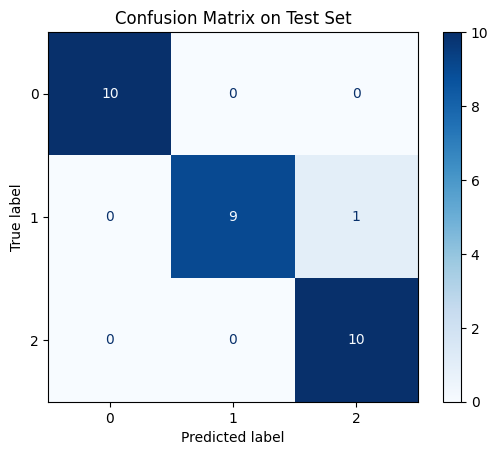

In [12]:

from sklearn.metrics import ConfusionMatrixDisplay

# Predict on test set
y_pred = grid.predict(X_test)

# Plot confusion matrix
ConfusionMatrixDisplay.from_predictions(y_test, y_pred, cmap='Blues')
plt.title("Confusion Matrix on Test Set")
plt.show()


##For smaller arrays it is ok, but for larger arrays the pkl file becomes slow

In [13]:
import pickle

# Save the entire GridSearchCV model
with open('best_random_forest_model.pkl', 'wb') as f:
    pickle.dump(grid.best_estimator_, f)


In [ ]:
with open('best_random_forest_model.pkl', 'rb') as f:
    loaded_model = pickle.load(f)

# Use loaded model to predict
y_loaded_pred = loaded_model.predict(X_test)


## For large array handling we use the joblib file format

In [14]:
import joblib

# Save the best estimator
joblib.dump(grid.best_estimator_, 'best_random_forest_model.joblib')


['best_random_forest_model.joblib']

In [ ]:
# Load the saved model
loaded_model = joblib.load('best_random_forest_model.joblib')

# Predict using the loaded model
y_loaded_pred = loaded_model.predict(X_test)